In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr

import ncar_jobqueue
import dask
import dask.distributed
import cftime

import esmlab
import intake
import intake_esm

import matplotlib.pyplot as plt

import util

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
molw_Fe = 55.845

kgm2s_to_molm2yr = 1e3 / molw_Fe * 86400. * 365.

In [3]:
col = intake.open_esm_metadatastore(collection_input_definition='collections.yml',
                                    overwrite_existing=True)

Working on experiment: ctrl
Getting file listing : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.004
Building file database : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.004
Working on experiment: xtfe
Getting file listing : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.xtfe.001
Building file database : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.xtfe.001
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 19 columns):
resource            1150 non-null object
resource_type       1150 non-null object
direct_access       1150 non-null object
description         1150 non-null object
experiment          1150 non-null object
case                1150 non-null object
component           1150 non-null object
stream              1150 non-null object
variable            1150 non-null object
date_range          1150 non-null object
ensemble            1150 non-null object
file_fullpath       1150 non-null object
file_basename       1150 non-null object
file_dirname        1150 non-null object
ctrl_branch_year    0 non-null object
year_offset         1150 non-null object
sequence_order      1150 non-null object
has_ocean_bgc       1150 non-null object
grid                1150 non-null object
dtypes: object(19)
memory usage: 170.8+ KB
Persisting xtfe-cesm-runs at : /glade/u/home/mclong/p/xtfe/intake-collecti

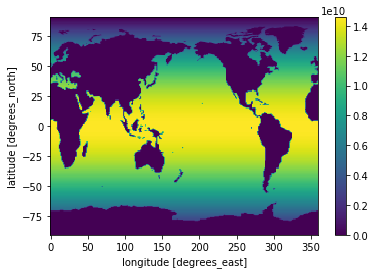

In [4]:
inputdata = '/glade/p/cesmdata/cseg/inputdata'

with xr.open_dataset(f'{inputdata}/atm/cam/ocnfrac/domain.camocn.0.9x1.25_gx1v7_170215.nc') as ds:
    OCNFRAC = ds.frac.rename({'nj': 'lat', 'ni': 'lon'})

with xr.open_dataset(f'{inputdata}/atm/cam/coords/fv_0.9x1.25.nc') as ds:
    AREA = xr.DataArray(util.compute_grid_area(ds).values, dims=('lat', 'lon'))
    lon = ds.lon
    lat = ds.lat

AREA['lon'] = lon
AREA['lat'] = lat
OCNFRAC['lon'] = lon
OCNFRAC['lat'] = lat
    
AREA = AREA * OCNFRAC

AREA.plot()

In [5]:
presaero_path = '/glade/work/mclong/cesm_cases/xtfe/data/forcing'
presaero_file = 'aerosoldep_WACCM.ensmean_monthly_hist_1849-2015_0.9x1.25_CMIP6_c180926-xtfe.nc'
ds5 = xr.open_dataset(f'{presaero_path}/{presaero_file}')

ds5 = ds5.sel(time='2000')

ds5['time_bnd_diff'] = xr.DataArray(np.diff(cftime.date2num(ds5.time_bnds, 
                                                            units='days since 0001-01-01', 
                                                            calendar='noleap'), axis=1)[:, 0]/365., 
                                    dims=('time'), 
                                    coords={'time': ds5.time})

ds5.time_bnd_diff['units'] = 'year'

# overwrite coords to deal with round-off level diffs
ds5['lon'] = lon
ds5['lat'] = lat
ds5 = ds5.reindex({'lat': lat, 'lon': lon})
ds5

<xarray.Dataset>
Dimensions:        (lat: 192, lon: 288, ntb: 2, time: 12)
Coordinates:
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time           (time) object 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
Dimensions without coordinates: ntb
Data variables:
    BCDEPWET       (time, lat, lon) float32 5.856115e-16 ... 2.5941094e-14
    BCPHIDRY       (time, lat, lon) float32 7.165252e-17 ... 3.9884753e-15
    BCPHODRY       (time, lat, lon) float32 8.384732e-18 ... 1.0866273e-14
    DSTX01DD       (time, lat, lon) float32 3.4760406e-17 ... 3.7529557e-15
    DSTX01WD       (time, lat, lon) float32 3.5114018e-16 ... 1.3153321e-14
    DSTX02DD       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DSTX02WD       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DSTX03DD       (time, lat, lon) float32 2.1564233e-16 ... 4.3515725e-14
    DSTX03

## Load CESM simulation data

In [55]:
data_vars = ['IRON_FLUX', 'ATM_XTFE_FLUX_CPL', 'SEAICE_XTFE_FLUX_CPL']

ds = util.open_cesm_data(col, data_vars, time_slice=slice('0020', '0032'))

xtfe: Ocean-ice hindcast, XT-Fe forcing 100% soluble
ctrl: Ocean-ice hindcast, control


## Compare XT Fe global integrals

### "Truth": computed directly from forcing dataset

In [53]:
datm_xtfe_glb = esmlab.weighted_sum(ds5.EXTTERFE * kgm2s_to_molm2yr, weights=AREA, dim=['lat', 'lon']) * 1e-9 # mol --> Gmol
datm_xtfe_glb = esmlab.weighted_sum(datm_xtfe_glb, weights=ds5.time_bnd_diff, dim=('time'))
print(f'Annual global XT Fe deposition: {datm_xtfe_glb.values:0.6f} Gmol')


Annual global XT Fe deposition: 0.064768 Gmol


### Computed from difference in `IRON_FLUX` variable between `xtfe` and `ctrl`

Since the model is using a repeating annual cycle, an average over all years helps smooth out some of the temporal shifting of the flux mediating by sea ice.

In [59]:
xtfe_flux = ds.IRON_FLUX.sel(experiment='xtfe') - ds.IRON_FLUX.sel(experiment='ctrl')

pop_xtfe_glb = esmlab.weighted_sum(xtfe_flux, weights=ds.TAREA*1e-4, dim=['nlat', 'nlon']) * 1e-9 # mol --> Gmol
pop_xtfe_glb = esmlab.weighted_sum(pop_xtfe_glb, weights=ds.time_bound_diff, dim=('time'))

pop_xtfe_glb = pop_xtfe_glb / (len(ds.time) / 12)
print(f'Annual global XT Fe deposition: {pop_xtfe_glb.values:0.6f}')


Annual global XT Fe deposition: 0.064851


### Computed from fields from the coupler

In [58]:
xtfe_flux = (ds.ATM_XTFE_FLUX_CPL + ds.SEAICE_XTFE_FLUX_CPL) 

pop_xtfe_glb = esmlab.weighted_sum(xtfe_flux, weights=ds.TAREA*1e-4, dim=['nlat', 'nlon']) * 1e-9 # mol --> Gmol
pop_xtfe_glb = esmlab.weighted_sum(pop_xtfe_glb, weights=ds.time_bound_diff, dim=('time'))

pop_xtfe_glb = pop_xtfe_glb / (len(ds.time) / 12)

print(f'Annual global XT Fe deposition: {pop_xtfe_glb.values:0.6f}')


Annual global XT Fe deposition: 0.064846
